
# 1. Defining the problem statement
Complete the analysis of what sorts of people were likely to survive.
In particular, we ask you to apply the tools of machine learning to predict which passengers survived the Titanic tragedy.


In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

# 2. Collecting the data

In [6]:
# 주어진 데이터를 훈련하기 위해 데이터를 download\
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub_df = pd.read_csv('gender_submission.csv')

# 3. EDA(Exploratory Data Analysis) & Data Preprocessing
## df :데이터 셋 확인
* shape(row*col), info():피쳐이름,타입 ,  head():데이터샘플

In [8]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 결측치 처리 (Missing value treatment)
### NaN null nan np.nan

In [4]:
train_test = train.append(test)
nan_dict = {"CNT":train_test.isna().sum(),
            "RATE": train_test.isna().sum()/train.shape[0] *100
}
nan_df = pd.DataFrame(nan_dict)
print(nan_df[nan_df["RATE"]>0].sort_values("CNT", ascending=False))


           CNT        RATE
Cabin     1014  113.804714
Survived   418   46.913580
Age        263   29.517396
Embarked     2    0.224467
Fare         1    0.112233


### Cabin : U0

In [5]:
# print(train["Cabin"].head())
print(train_test["Cabin"].describe())   #[nan 'C85' 'C123' 'E46' 'G6']
train["Cabin"].fillna("", inplace=True)
test["Cabin"].fillna("", inplace=True)

train["Cabin_title"] = train["Cabin"].str[:1]
test["Cabin_title"] = test["Cabin"].str[:1]

count             295
unique            186
top       C23 C25 C27
freq                6
Name: Cabin, dtype: object


In [6]:
cross = pd.crosstab(train["Cabin_title"], train["Survived"])
print(cross)

Survived       0    1
Cabin_title          
             481  206
A              8    7
B             12   35
C             24   35
D              8   25
E              8   24
F              5    8
G              2    2
T              1    0


In [7]:
cross = pd.crosstab(train["Cabin_title"], train["Pclass"])
print(cross)

Pclass        1    2    3
Cabin_title              
             40  168  479
A            15    0    0
B            47    0    0
C            59    0    0
D            29    4    0
E            25    4    3
F             0    8    5
G             0    0    4
T             1    0    0


<pre>
객실 title은 Pclass=1 이 대부분
2~3에 해당 사항없음
결측 처리 대상에서 제외 - 해당 피쳐 삭제

### Age : 이름 호칭별 그룹 평균

* 나이 분포 확인

In [8]:
print(train["Age"].describe())

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


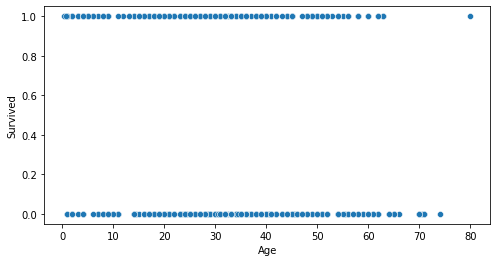

In [9]:
plt.figure(figsize=(8,4))
sns.scatterplot(x="Age", y="Survived", data=train);

* 이름의 호칭을 사용해 평균 나이로 결측 처리

In [10]:
train['Name_title'] = train['Name'].str.extract(' ([A-Za-z]+)\.')
test['Name_title'] = test['Name'].str.extract(' ([A-Za-z]+)\.')
print(test['Name_title'].unique())
print(train['Name_title'].unique())


['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']
['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']


In [11]:
temp_data = pd.concat([train['Name_title'], test['Name_title']])
print(type(temp_data))   #<class 'pandas.core.series.Series'>
temp_data.value_counts()  #1300 , Mr          757  500
# print(temp_data.shape)

<class 'pandas.core.series.Series'>


Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Ms            2
Major         2
Mlle          2
Lady          1
Don           1
Countess      1
Capt          1
Jonkheer      1
Sir           1
Dona          1
Mme           1
Name: Name_title, dtype: int64

In [12]:
name_title_dict = {
'Mr':1,
'Mrs':2, 'Mme':2,
'Miss':3, 'Lady':3, 'Ms' :3,'Mlle':3,
'Master':4 ,
    'Don':5 , 'Dona':5, 'Rev':6 , 'Dr':7 , 'Major':8 ,
 'Sir':9, 'Col':10, 'Capt':11, 'Countess':12, 'Jonkheer':13
}
train['Name_title'] = train['Name_title'].map(name_title_dict)
test['Name_title'] = test['Name_title'].map(name_title_dict)
print(train['Name_title'].head())


0    1
1    2
2    3
3    2
4    1
Name: Name_title, dtype: int64


In [13]:
train["Age"].fillna(train.groupby("Name_title")["Age"].transform("mean"), inplace=True)
test["Age"].fillna(test.groupby("Name_title")["Age"].transform("mean"), inplace=True)
print(train["Age"].unique())

[22.         38.         26.         35.         32.36809045 54.
  2.         27.         14.          4.         58.         20.
 39.         55.         31.         35.78899083 34.         15.
 28.          8.         19.         22.02       40.         66.
 42.         21.         18.          3.          7.         49.
 29.         65.         28.5         5.         11.         45.
  4.57416667 17.         32.         16.         25.          0.83
 30.         33.         23.         24.         46.         59.
 71.         37.         47.         14.5        70.5        32.5
 12.          9.         36.5        51.         55.5        40.5
 44.          1.         61.         56.         50.         36.
 45.5        20.5        62.         41.         52.         63.
 23.5         0.92       43.         60.         10.         64.
 13.         48.          0.75       53.         57.         80.
 70.         24.5         6.          0.67       30.5         0.42
 34.5        74.   

* 파생변수 : 이름의 호칭 카테고리화

In [14]:
# train['T_MR'] = train['Name_title']==Mr 1  0
train["T_MR"] = train["Name_title"].apply(lambda x:  1 if x == "Mr" else 0)
test["T_MR"] = test["Name_title"].apply(lambda x:  1 if x == "Mr" else 0)
test["T_MR"][:5]

0    0
1    0
2    0
3    0
4    0
Name: T_MR, dtype: int64

### Embarked      : 최빈도

In [15]:
temp_data = pd.concat([train['Embarked'], test['Embarked']])
temp_data.describe()

count     1307
unique       3
top          S
freq       914
Name: Embarked, dtype: object

In [16]:
print(train["Embarked"].unique())

['S' 'C' 'Q' nan]


In [17]:
mode_value = train["Embarked"].mode()
print(mode_value, type(mode_value))
# train["Embarked"] = train["Embarked"].fillna(mode_value) # , inplace=True)
# test["Embarked"] = test["Embarked"].fillna(mode_value) #  , inplace=True)

0    S
dtype: object <class 'pandas.core.series.Series'>


In [18]:
mode_value = 'S'
train["Embarked"].fillna(mode_value, inplace=True)
test["Embarked"].fillna(mode_value, inplace=True)
# train["Embarked"] = train["Embarked"].replace(np.nan, 'S')
# test["Embarked"] = test["Embarked"].replace(np.nan, 'S')

In [19]:
print(train["Embarked"].unique())

['S' 'C' 'Q']


### Fare : 0

In [20]:
train["Fare"].fillna(0, inplace=True)
test["Fare"].fillna(0, inplace=True)

## -- family name, Ticket,   T_family = (SibSp+Parch)+1  > 2
   - Survived 생존률 rate 가중치 부여

In [21]:
print(train.isna().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Cabin_title    0
Name_title     0
T_MR           0
dtype: int64


In [22]:
print(test.isna().sum())

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Cabin_title    0
Name_title     0
T_MR           0
dtype: int64


# 4. Feature Converting  -- T......Engineering

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
 12  Cabin_title  891 non-null    object 
 13  Name_title   891 non-null    int64  
 14  T_MR         891 non-null    int64  
dtypes: float64(2), int64(7), object(6)
memory usage: 104.5+ KB


<pre>
--------------------------------------------- 
5   Age          714 non-null    float64 -- Name_title평균나이, T_MR:0,1
10  Cabin        204 non-null    object -- 삭제
11  Embarked     889 non-null    object -- 'S' 최빈값
---------------------------------------------
3   Name         891 non-null    object -- 삭제
4   Sex          891 non-null    object -- m:1 f:0
8   Ticket       891 non-null    object -- 삭제
10  Cabin        204 non-null    object -- 삭제
*   Cabin_title  204 non-null    object -- 삭제
11  Embarked     889 non-null    object -- S:1~2
----------------------------------------------
T_family = (SibSp+Parch)+1

### Object 타입 numeric화

In [24]:
# train.select_dtypes(include='object')

In [25]:
train[["Embarked","Sex"]].describe()

,Embarked,Sex
count,891,891
unique,3,2
top,S,male
freq,646,577


In [26]:
# temp = pd.concat([train, test])
train_test = [train, test]
for df in train_test:
#   1. map
    sex_dict = {'male':1,'female':0}
    df['T_sex'] = df['Sex'].map(sex_dict)
    
    emb_dict = {'Q':0 , 'S':1 , 'C':2}
    df['T_embarked'] = df['Embarked'].map(emb_dict)

    df["T_family"] = (df["SibSp"] + df["Parch"]) + 1
#     print(train['T_sex'].head())
    
#     2. lambda
#     train["T_sex2"] = train["Sex"].apply(lambda x:  1 if x == "male" else 0)
#     print(train['T_sex'].head())
    
#     3. replace
#     train["T_sex3"] = train["Sex"].replace('male', 1)
#     train["T_sex3"] = train["T_sex3"].replace('female', 0)
#     print(train['T_sex3'].head())

In [27]:
train[['T_embarked','Embarked']].head()

,T_embarked,Embarked
0,1,S
1,2,C
2,1,S
3,1,S
4,1,S


In [28]:
#--------------------------------------------------------------------
# 4. get_dummy() : DataFrame  ,  retrun DataFrame --> DataFrame
#--------------------------------------------------------------------
# dummy_df = pd.get_dummies(train["Sex"])
# # train = pd.concat(train,dummy_df)
# train = train.join(dummy_df)
# print(train.info())

In [29]:
# train[["Sex","female","male"]].head()

In [30]:
#--------------------------------------------------------------------
# Encoder : like array  ,  retrun like array --> DataFrame
#--------------------------------------------------------------------
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from scipy.sparse import csr_matrix

# le_encoder = LabelEncoder()
# #train[["Sex","Embarker"]] = encoder.fit_transform(train[["Sex","Embarker"]])   XXXXXX
# cols = ["Sex",]
# for col in cols:   
#     train["LE_"+col] = le_encoder.fit_transform(train[col])
#     print(train[["Sex", "LE_Sex"]].head())
# #     print(np.array(train["LE_"+col]).reshape(-1, 1))
#     oh_encoder = OneHotEncoder()    
#     res = oh_encoder.fit_transform(np.array(train["LE_"+col]).reshape(-1, 1))   #[[],[],[]]
#     print(type(res), res.shape)
    
#     csr_df = pd.DataFrame.sparse.from_spmatrix(res, columns=['OH_M', 'OH_F'])  
    
# train = train.append(csr_df)
# # dtype = pd.SparseDtype(np.float64, fill_value=0)
# # train['OH_M'].astype(dtype)
# train.info()

In [31]:
#--------------------------------------------------------------------
# Encoder : like array  ,  retrun like array --> like array
#--------------------------------------------------------------------
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# item = ["b","a","c","d","e","f","g"]
# encoder = LabelEncoder()  #글자-->숫자
# # encoder.fit(item)
# # res = encoder.transform(item)
# res = encoder.fit_transform(item)
# print(encoder.classes_)
# print(res)   #[1 0 2 3 4 5 6]
# print(encoder.inverse_transform(res))

# oh_encoder = OneHotEncoder()
# re_res = res.reshape(-1,1)  #------------------[[],[],[],[]]
# res = oh_encoder.fit_transform(re_res)
# print(res.shape)
# print(res)

#-------------------- [LabelEncoder, OneHotEncoder] + 결측처리**
# import pandas as pd
# df = pd.DataFrame({"key" : ["b","a","c","d","e","f","g"]})
# print(df.head())
# df = pd.get_dummies(df["key"])
# print(df.head())

### Float 타입 numeric화

In [32]:
# dataset["Age"] = train_df["Age"].astype(int)

In [33]:
float_features_list = train.dtypes[train.dtypes == 'float64'].index.values
print(float_features_list)
train[float_features_list] = train[float_features_list].astype(np.int32)
test[float_features_list] = test[float_features_list].astype(np.int32)

['Age' 'Fare']


### 불필요한 피쳐 삭제

In [34]:
object_features_list = train.dtypes[train.dtypes == 'object'].index.values
print(object_features_list)

['Name' 'Sex' 'Ticket' 'Cabin' 'Embarked' 'Cabin_title']


In [35]:
train.drop(object_features_list, axis=1, inplace=True)
test.drop(object_features_list, axis=1, inplace=True)

In [36]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  891 non-null    int64
 1   Survived     891 non-null    int64
 2   Pclass       891 non-null    int64
 3   Age          891 non-null    int32
 4   SibSp        891 non-null    int64
 5   Parch        891 non-null    int64
 6   Fare         891 non-null    int32
 7   Name_title   891 non-null    int64
 8   T_MR         891 non-null    int64
 9   T_sex        891 non-null    int64
 10  T_embarked   891 non-null    int64
 11  T_family     891 non-null    int64
dtypes: int32(2), int64(10)
memory usage: 76.7 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Pclass       418 non-null    int64
 2   Age       

In [37]:

train.drop('PassengerId', axis=1, inplace=True)
test.drop('PassengerId', axis=1, inplace=True)

# 모델 선정 및 학습 : 우선 점수부터 보고 이후 작업 더 진행

<pre>
모델 분석에 필요한 데이터 종류 : train[train set : validation set] , test set
                                    train_test_split
* classification(분류) 모델선정 : 문제집 선택
* 학습     : fit(문제train8, 정답train_Survived8)
* 모의고사 : predict(모의시험지train2=validation) ----- 예측답안
* 모의채점 : _score(예측답안, 모의고사정답지train2=validation)
*---------------------------------------------------------------------    
* 본시험   : predict(본시험지test)   ----- 예측답안
* 본채점   : _score(예측답안submission, 본시험정답지kaggle-leaderboard)

In [38]:
# ! pip install lightgbm
# ! pip install xgboost

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# XGBoost python wrapper class
# ref : https://injo.tistory.com/44
# ref : https://velog.io/@dbj2000/ML
import xgboost as xgb ## XGBoost 불러오기

#LightGBM
# ref : https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score, recall_score, f1_score, roc_auc_score

* 정확도(Accuracy)
Accuracy = (TP + TN)/(TP + TN + FP + FN)

#### 1. 학습.답안 데이터 셋 분리

In [40]:
train_y = train["Survived"]
train_X = train.drop("Survived", axis=1)
print(train_y.shape, train_X.shape)

(891,) (891, 10)


#### 2..학습'답안/검증'답안 데이터 셋 분리

In [41]:
문제_학습8, 문제_검증2, 답안_학습8, 답안_검증2 = train_test_split(train_X, train_y, test_size=0.2, random_state=36,  shuffle=False)
print(문제_학습8.shape, 문제_검증2.shape, 답안_학습8.shape, 답안_검증2.shape)

(712, 10) (179, 10) (712,) (179,)


In [42]:
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
lr = LogisticRegression()
knn = KNeighborsClassifier()

In [43]:
dt.fit(문제_학습8, 답안_학습8)
내가낸답안2 = dt.predict(문제_검증2)
df_score = accuracy_score(내가낸답안2 ,  답안_검증2)
print(df_score)     # 0.7541899441340782  float 
                    # 0.7653631284916201  int

0.7597765363128491


In [44]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Pclass      891 non-null    int64
 1   Age         891 non-null    int32
 2   SibSp       891 non-null    int64
 3   Parch       891 non-null    int64
 4   Fare        891 non-null    int32
 5   Name_title  891 non-null    int64
 6   T_MR        891 non-null    int64
 7   T_sex       891 non-null    int64
 8   T_embarked  891 non-null    int64
 9   T_family    891 non-null    int64
dtypes: int32(2), int64(8)
memory usage: 62.8 KB


# 기초 통계를 활용한 피쳐 분석

### Featue Importance

In [45]:
# dt.feature_importances_

In [46]:
imp_df = pd.DataFrame({"featuer" : train_X.columns, "importance" : dt.feature_importances_})
imp_df.sort_values('importance', ascending=False).T


,5,1,4,0,9,8,2,3,6,7
featuer,Name_title,Age,Fare,Pclass,T_family,T_embarked,SibSp,Parch,T_MR,T_sex
importance,0.369821,0.222685,0.169556,0.107453,0.059777,0.039934,0.017413,0.013361,0.0,0.0


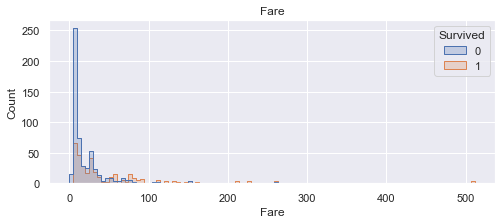

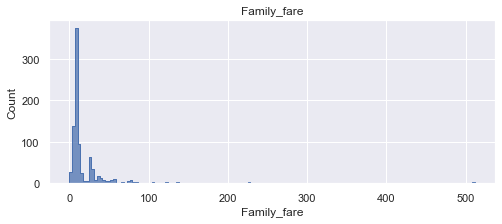

In [47]:
train_X["Fare"] = train["Fare"]
train_X["Family_fare"] = train_X["Fare"]/ train_X["T_family"]
test["Family_fare"] = test["Fare"]/ test["T_family"]

sns.set()
fig, axes = plt.subplots(ncols=1, figsize=(8, 3))
ax = sns.histplot(train, x="Fare",hue="Survived", element="step", ax=axes)
ax.set_title("Fare")
plt.show()

sns.set()
fig, axes = plt.subplots(ncols=1, figsize=(8,3))
ax = sns.histplot(train_X, x="Family_fare", element="step", ax=axes)
ax.set_title("Family_fare")
plt.show()



In [48]:
# imp_df.plot.bar()

In [49]:
# train_X.loc[ train_X['Age'] <= 16, 'Age'] = 0
# train_X.loc[(train_X['Age'] > 16) & (train_X['Age'] <= 26), 'Age'] = 1
# train_X.loc[(train_X['Age'] > 26) & (train_X['Age'] <= 36), 'Age'] = 2
# train_X.loc[(train_X['Age'] > 36) & (train_X['Age'] <= 62), 'Age'] = 3
# train_X.loc[train_X['Age'] > 62, 'Age'] = 4

### Fare : 최소 요금 약 7달러로 구간화

In [50]:
# def fare_bining(x) :  #df["Fear"]
#     T_fare = 0
#     if x <= 7:
#         T_fare = 1
#     elif  x <= 14:
#         T_fare = 2
#     elif  x <= 21:
#         T_fare = 3
#     else:
#         T_fare = 4
#     return  T_fare   
# train_X["T_Fare"] = train_X["Fare"].apply(lambda x : fare_bining(x))
#--------------------------------------------------------------------------------------------
train_X["T_Fare"] = train_X["Fare"].apply(lambda x : x//14)
train_X["T_Fare"] = train_X["T_Fare"].astype(int)
print(train_X[["T_Fare","Fare"]].head(8))
test["T_Fare"] = test["Fare"].apply(lambda x : x//14)
test["T_Fare"] = test["T_Fare"].astype(int)

print(train_X.info())

   T_Fare  Fare
0       0     7
1       5    71
2       0     7
3       3    53
4       0     8
5       0     8
6       3    51
7       1    21
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       891 non-null    int64  
 1   Age          891 non-null    int32  
 2   SibSp        891 non-null    int64  
 3   Parch        891 non-null    int64  
 4   Fare         891 non-null    int32  
 5   Name_title   891 non-null    int64  
 6   T_MR         891 non-null    int64  
 7   T_sex        891 non-null    int64  
 8   T_embarked   891 non-null    int64  
 9   T_family     891 non-null    int64  
 10  Family_fare  891 non-null    float64
 11  T_Fare       891 non-null    int32  
dtypes: float64(1), int32(3), int64(8)
memory usage: 73.2 KB
None


In [51]:
def myfit(X, y, model, imp=0, tsize=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize, random_state=36,  shuffle=False)
    #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    df_score = accuracy_score(pred ,  y_test)
    print("Accuracy : {:.6f}".format(df_score))     
    if imp==1:         
        imp_df = pd.DataFrame({"featuer" : train_X.columns, "importance" : model.feature_importances_})
        imp_df = imp_df.sort_values('importance', ascending=False).T
        print(imp_df)

In [52]:
myfit(train_X, train_y, dt)  #0.7597765363128491

Accuracy : 0.759777


In [53]:
train_X.drop(["Fare"], inplace=True, axis=1)
test.drop(["Fare"], inplace=True, axis=1)

In [54]:
myfit(train_X, train_y, dt, 1)  #0.798883

Accuracy : 0.765363
                    4         1            9        0         8         10  \
featuer     Name_title       Age  Family_fare   Pclass  T_family    T_Fare   
importance    0.366695  0.257362     0.125379  0.09312  0.064607  0.047388   

                    7         2         3     5      6   
featuer     T_embarked     SibSp     Parch  T_MR  T_sex  
importance     0.03062  0.008345  0.006483   0.0    0.0  


### Age : 구간화

In [55]:
temp = train_X.copy()
temp = temp.join(train_y)
temp.head()

,Pclass,Age,SibSp,Parch,Name_title,T_MR,T_sex,T_embarked,T_family,Family_fare,T_Fare,Survived
0,3,22,1,0,1,0,1,1,2,3.5,0,0
1,1,38,1,0,2,0,0,2,2,35.5,5,1
2,3,26,0,0,3,0,0,1,1,7.0,0,1
3,1,35,1,0,2,0,0,1,2,26.5,3,1
4,3,35,0,0,1,0,1,1,1,8.0,0,0


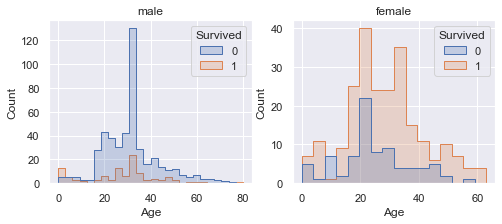

In [56]:
sns.set()
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
ax = sns.histplot(temp[temp["T_sex"]==1], x="Age", hue="Survived", element="step", ax=axes[0])
ax.set_title("male")
ax = sns.histplot(temp[temp["T_sex"]==0], x="Age", hue="Survived", element="step", ax=axes[1])
ax.set_title("female")
plt.show()

In [57]:
# 0~17
# 18~38
# 39~60
# 60~
def age_bining(x) :  #df["Age"]
    T_Age = 0
    if x>0 & x <= 17:
        T_Age = 1
    elif x>17 & x <= 38:
        T_Age = 2
    elif  x>38 & x <= 60:
        T_Age = 3
    else:
        T_Age = 4
    return  T_Age   
train_X["T_Age"] = train_X["Age"].apply(lambda x : age_bining(x))
test["T_Age"] = test["Age"].apply(lambda x : age_bining(x))

In [58]:
myfit(train_X, train_y, dt)  #0.787709 --> 0.782123

Accuracy : 0.770950


In [59]:
train_X["T_Age"] = train_X["Age"].apply(lambda x : x//5)
train_X["T_Age"] = train_X["T_Age"].astype(int)
print(train_X[["T_Age","Age"]].head(8))

   T_Age  Age
0      4   22
1      7   38
2      5   26
3      7   35
4      7   35
5      6   32
6     10   54
7      0    2


In [60]:
myfit(train_X, train_y, dt)  #0.793296

Accuracy : 0.770950


In [61]:
# train_X.drop(["Age"], inplace=True, axis=1)

In [62]:
myfit(train_X, train_y, dt, 1)  #0.810056  //  0.815642

Accuracy : 0.770950
                    4         1            9         0         11        8   \
featuer     Name_title       Age  Family_fare    Pclass     T_Age  T_family   
importance    0.359888  0.182485     0.120639  0.091283  0.074773  0.064508   

                  10          7        2         3     5      6   
featuer       T_Fare  T_embarked    SibSp     Parch  T_MR  T_sex  
importance  0.057656    0.039342  0.00748  0.001945   0.0    0.0  


In [63]:
models = [dt,rf] #,lr,knn ]
for model in models:
    print(model.__class__)
    myfit(train_X, train_y, model, 1)  #0.810056  //  0.815642

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy : 0.754190
                    4         1            9         0         11        8   \
featuer     Name_title       Age  Family_fare    Pclass     T_Age  T_family   
importance    0.359888  0.185561     0.131322  0.097766  0.063306  0.060229   

                    7         10        2        3         6     5   
featuer     T_embarked    T_Fare     SibSp    Parch     T_sex  T_MR  
importance    0.042506  0.037144  0.010175  0.00778  0.004322   0.0  
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy : 0.826816
                    4            9         1         6        11        10  \
featuer     Name_title  Family_fare       Age     T_sex    T_Age    T_Fare   
importance    0.181228     0.163149  0.161512  0.141609  0.08618  0.065042   

                  0         8           7        2         3     5   
featuer       Pclass  T_family  T_embarked    SibSp     Parch  T_MR  
importance  0.064674   0

In [64]:
train_X["T_fare_per_one"] = train_X["T_Fare"] / train_X["T_family"]
test["T_fare_per_one"] = test["T_Fare"] / test["T_family"]

In [65]:
myfit(train_X, train_y, model, 1)  #0.849162

Accuracy : 0.804469
                  1         6           4            9         11        0   \
featuer          Age     T_sex  Name_title  Family_fare     T_Age    Pclass   
importance  0.162434  0.160148    0.154301     0.148732  0.085566  0.063035   

                        12        10        8           7         2   \
featuer     T_fare_per_one    T_Fare  T_family  T_embarked     SibSp   
importance        0.055639  0.043247  0.041181    0.037088  0.030189   

                  3     5   
featuer        Parch  T_MR  
importance  0.018439   0.0  


In [66]:
train_X["T_fare_per_one"].nunique()

36

In [67]:
train_X["T_fare_per_one"] = (train_X["T_Fare"] / train_X["T_family"]).astype(int)
test["T_fare_per_one"] = (test["T_Fare"] / test["T_family"]).astype(int)

In [68]:
train_X["T_fare_per_one"].nunique()

15

In [69]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Pclass          891 non-null    int64  
 1   Age             891 non-null    int32  
 2   SibSp           891 non-null    int64  
 3   Parch           891 non-null    int64  
 4   Name_title      891 non-null    int64  
 5   T_MR            891 non-null    int64  
 6   T_sex           891 non-null    int64  
 7   T_embarked      891 non-null    int64  
 8   T_family        891 non-null    int64  
 9   Family_fare     891 non-null    float64
 10  T_Fare          891 non-null    int32  
 11  T_Age           891 non-null    int32  
 12  T_fare_per_one  891 non-null    int32  
dtypes: float64(1), int32(4), int64(8)
memory usage: 76.7 KB


<AxesSubplot:xlabel='feature'>

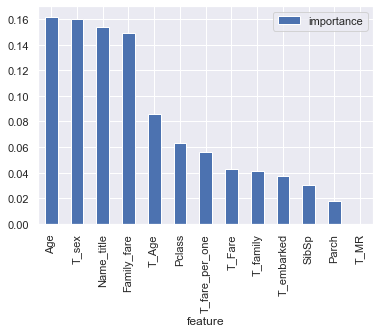

In [70]:
importances = pd.DataFrame({'feature':train_X.columns,'importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15).T
importances.plot.bar()



In [71]:
train_X.drop(['T_MR'], axis=1, inplace=True)
test.drop(['T_MR'], axis=1, inplace=True)


In [72]:
myfit(train_X, train_y, rf, 1)  #0.815642

Accuracy : 0.832402
                    4         1            8         5         10        0   \
featuer     Name_title       Age  Family_fare     T_sex     T_Age    Pclass   
importance     0.18803  0.165493     0.156126  0.140254  0.085204  0.060534   

                 9         7           6         2               11        3   
featuer      T_Fare  T_family  T_embarked     SibSp  T_fare_per_one     Parch  
importance  0.04944  0.045401    0.035168  0.030765        0.027321  0.016265  


## Ensemble Model

### 보팅 : VottingClassifier

In [73]:
from sklearn.ensemble import VotingClassifier

models = [('DT',dt), ('LR',lr), ('KNN',knn)]
vot = VotingClassifier(models, voting='hard' )   # weights=None
myfit(train_X, train_y, vot)   # 0.826816

Accuracy : 0.821229


In [74]:
models = [('DT',dt), ('LR',lr), ('KNN',knn)]
for model in models:
    print(model[0])
    myfit(train_X, train_y, model[1])   

DT
Accuracy : 0.776536
LR
Accuracy : 0.810056
KNN
Accuracy : 0.782123


### 배깅 : Bagging
* 하이퍼파라미터 : 학습 후 예측결과에 영향을 끼치는 파라미터
* 하이퍼파라미터 튜닝 : 파라미터 수치를 고치는 행위

In [75]:
my_param = {"n_estimators":[100,300,500],
            "max_depth":[1,2,3,4,5],
            "min_samples_split":[1,2,3]
            }
bagg100 = RandomForestClassifier(n_estimators=100,max_depth=1)  #0.804469
myfit(train_X, train_y, bagg100)

Accuracy : 0.804469


In [132]:
bagg = RandomForestClassifier(n_estimators=100,max_depth=10)  # 0.865922
myfit(train_X, train_y, bagg)

Accuracy : 0.860335


In [77]:
# 0.854749  0.849162 0.849162 0.854749  0.849162 0.849162 0.854749  0.849162 0.849162

In [133]:
pred_for_submit = bagg.predict(test)
#답지 수가 맞는지 확인
print(sub_df.shape)
print(len(pred_for_submit))
sub_df["Survived"] = np.array(pred_for_submit).reshape(-1, 1)
sub_df.to_csv("bagg_submission.csv", index=False)

(418, 2)
418


# 검증

### KFold

In [78]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

N_SPLIT = 5
# kfold = KFold(n_splits=5, shuffle=True, random_state=131)
kfold = KFold(n_splits=N_SPLIT, shuffle=False)
scores = []
for train_index, test_index in kfold.split(train_X):  #-----------StratifiedKFold
    print("TRAIN:", len(train_index) , "TEST:", len(test_index))
    X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
    y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
    bagg.fit(X_train, y_train)
    pred = bagg.predict(X_test)
    df_score = accuracy_score(pred, y_test)
    scores.append(df_score)
    print("Accuracy : {:.6f}".format(df_score))
print("{:d}회 평균 Accuracy:{:.4f}".format(N_SPLIT, np.array(scores).mean()))   #0.8539

TRAIN: 712 TEST: 179
Accuracy : 0.821229
TRAIN: 713 TEST: 178
Accuracy : 0.808989
TRAIN: 713 TEST: 178
Accuracy : 0.837079
TRAIN: 713 TEST: 178
Accuracy : 0.797753
TRAIN: 713 TEST: 178
Accuracy : 0.853933
5회 평균 Accuracy:0.8238


### StratifiedKFold

In [130]:
from sklearn.model_selection import StratifiedKFold
skfold = StratifiedKFold(n_splits=5, shuffle=False)
scores = []
for train_index, test_index in skfold.split(train_X, train_y):
    print("TRAIN:", len(train_index) , "TEST:", len(test_index))
    X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
    y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
    bagg.fit(X_train, y_train)
    pred = bagg.predict(X_test)
    df_score = accuracy_score(pred, y_test)
    scores.append(df_score)
    print("Accuracy : {:.6f}".format(df_score))
print("{:d}회 평균 Accuracy:{:.4f}".format(N_SPLIT,  np.array(scores).mean()))   #0.8483

TRAIN: 712 TEST: 179
Accuracy : 0.810056
TRAIN: 713 TEST: 178
Accuracy : 0.803371
TRAIN: 713 TEST: 178
Accuracy : 0.848315
TRAIN: 713 TEST: 178
Accuracy : 0.814607
TRAIN: 713 TEST: 178
Accuracy : 0.859551
5회 평균 Accuracy:0.8272


(418, 2)
418


In [80]:
# train_X['Age_Class']= train_X['Age']* train_X['Pclass']

In [81]:
# rf = RandomForestClassifier(n_estimators=100)
# myfit(train_X, train_y, rf, 1)  #0.843575

In [82]:
# importances = pd.DataFrame({'feature':train_X.columns,'importance':np.round(rf.feature_importances_,3)})
# importances = importances.sort_values('importance',ascending=False).set_index('feature')
# importances.head(15).T
# importances.plot.bar()

In [83]:
# train_X.head()

In [84]:
# param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}
# from sklearn.model_selection import GridSearchCV, cross_val_score
# rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
# clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
# clf.fit(train_X, train_y)
# clf.best_score_

## cross_val_score

In [85]:
from sklearn.model_selection import cross_val_score

In [86]:
# scoring: https://scikit-learn.org/stable/modules/model_evaluation.html
scores_list = cross_val_score(rf, train_X, train_y, cv=5, scoring="accuracy")

In [87]:
print(scores_list)
print(scores_list.mean())

[0.79888268 0.79775281 0.84269663 0.79213483 0.82022472]
0.8103383340656581


# GridSearchCV: 하이퍼파라미터 튜닝

In [88]:
from sklearn.model_selection import GridSearchCV

In [120]:
my_param = {"n_estimators":[100,300,500],
           "max_depth": [1,2,3,4,5,8,10],
           "min_samples_split":[1,2,3]}

gcv = GridSearchCV(rf, param_grid=my_param, scoring='accuracy', refit=True, cv=5)    

In [121]:
gcv.fit(train_X, train_y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 8, 10],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [100, 300, 500]},
             scoring='accuracy')

In [91]:
print(gcv.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_min_samples_split', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


In [122]:
print(gcv.best_score_)  #0.8282781997363632

0.8327788588286987


In [123]:
print(gcv.best_params_)

{'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 500}


## 방법1: gender_submission.csv

In [124]:
pred_for_submit = gcv.predict(test)

In [125]:
sub_df   #답안지 샘플

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [126]:
#답지 수가 맞는지 확인
print(sub_df.shape)
print(len(pred_for_submit))

(418, 2)
418


In [127]:
sub_df["Survived"] = np.array(pred_for_submit).reshape(-1, 1)

In [128]:
sub_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [129]:
sub_df.to_csv("jyj_submission2.csv", index=False)

## 방법2: jyj_submission.csv

In [111]:
mydic = {"PassengerID": sub_df["PassengerID"].values,
"Survived": pred_for_submit}

final_df = pd.DataFrame(mydic)

In [112]:
final_df

,PassengerID,Survived
0,0,0
1,1,1
2,0,0
3,0,0
4,1,1
...,...,...
413,0,0
414,1,1
415,0,0
416,0,0


In [113]:
final_df.to_csv("jyj_submission.csv", index=False)